In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

# Change to your data directory
basedir = Path('/Volumes/data-1/behavior/hakan')


### Load data


In [3]:
data_path = basedir/'Kucukdereli_atal_data/data_table_all_mice.h5'

data_df = pd.read_hdf(data_path, key='data')


In [4]:
# Additional imports and setting up the plots
import json
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt

font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('axes', linewidth=0.8)

colors = {'gray':'#D4D4D4', 'darkgray':'#545454', 
          'male':'#FF5E74', 'male_light':'#FFABB6', 
          'female':'#00B7FF', 'female_light':'#9EE3FF'}


## Figure 3A

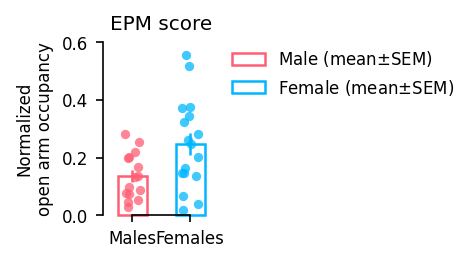

In [81]:
fig, ax = plt.subplots(1,1,figsize=(1.,1.5), dpi=150)

for i, sex in enumerate(['male','female']):
    df = data_df.query('@data_df.mouse.sex==@sex')

    jitter = 0.15
    xs_jittered = i + np.random.uniform(-jitter, jitter, size=len(df))

    ax.scatter(xs_jittered, df.epm.ratio, s=20, color=colors[sex], linewidth=0, alpha=0.75, clip_on=False, zorder=1)
    ax.bar(i, df.epm.ratio.mean(), yerr=df.epm.ratio.sem(axis=0), width=0.5,
            clip_on=False, zorder=1, fill=False, edgecolor=[colors[f'{sex}'],colors[f'{sex}_light']], linewidth=1.2,
            error_kw={'capsize':0, 'elinewidth':1.2, 'ecolor':[colors[f'{sex}'],colors[f'{sex}_light']]}, label=f'{sex[0].upper()}{sex[1:]} ' + r'(mean$\pm$SEM)')

ax.set_xlim([-0.5, 1.5])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Males', 'Females'])

ax.set_ylim([0, 0.6])
ax.set_ylabel('Normalized\nopen arm occupancy')
ax.set_title('EPM score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8, frameon=False)

ax.spines[['top','right']].set_visible(False)
ax.spines['bottom'].set_bounds(0,1)


## Figure 3B

In [101]:
# Additional imports
from scipy.stats import bartlett


In [83]:
def bootVar(arr, n_shuffle=1000):
    """
    Bootstrap the variance of an array
    
    Parameters
    ----------
    arr : array
        Array of values
    n_shuffle : int
        Number of shuffles

    Returns
    -------
    vars : array
        Array of variances
    """
    vars = np.zeros(n_shuffle)
    n = len(arr)
    for i in range(n_shuffle):
        sample = np.random.choice(arr, size=n, replace=True)
        vars[i] = np.var(sample, ddof=1)

    return vars


Bartlett's Test Statistic: 5.899484325676933, P= 0.015145318381436826, True


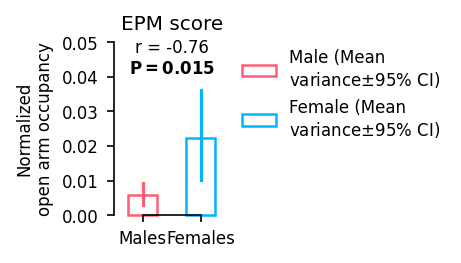

In [125]:
fig, ax = plt.subplots(1,1,figsize=(1.,1.5), dpi=150)

for i, sex in enumerate(['male','female']):
    epm_df = data_df.query('@data_df.mouse.sex==@sex')[('epm','ratio')]

    vars = bootVar(epm_df, n_shuffle=1000)
    var_mean = np.mean(vars)
    var_ci = np.percentile(vars, [2.5, 97.5])

    ax.bar(i, var_mean, width=0.5, clip_on=False, zorder=1, fill=False, linewidth=1.2,
           edgecolor=[colors[f'{sex}'],colors[f'{sex}_light']], 
           error_kw={'capsize':0, 'elinewidth':1.2, 'ecolor':[colors[f'{sex}'],colors[f'{sex}_light']]}, 
           label=f'{sex[0].upper()}{sex[1:]} ' + f'(Mean\n' + r'variance$\pm$95% CI)')
    
    ax.plot([i,i], var_ci, color=colors[f'{sex}'])

ax.set_xlim([-0.5, 1.5])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Males', 'Females'])

ax.set_ylim([0, 0.05])
ax.set_ylabel('Normalized\nopen arm occupancy')
ax.set_title('EPM score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8, frameon=False)

ax.spines[['top','right']].set_visible(False)
ax.spines['bottom'].set_bounds(0,1)

# Bartlett's test
bartlett_stat, bartlett_p = bartlett(data_df.query('@data_df.mouse.sex=="male"')[('epm','ratio')],
                                     data_df.query('@data_df.mouse.sex=="female"')[('epm','ratio')])

# Correct for multiple comparisons
alpha = 0.05
if bartlett_p < alpha:
    txt = f'r = {np.round(r,2)}\n'+fr'$\bf{{P= {np.round(bartlett_p,3)}}}$'
else:
    txt = f'r = {np.round(r,2)}\n'+f'P= {np.round(bartlett_p,3)}'
ax.annotate(txt, xy=(0.5, 0.82), xycoords='axes fraction', ha='center')

print(f"Bartlett's Test Statistic: {bartlett_stat}, P= {bartlett_p}, {bartlett_p<0.05}")


## Figures 3C and S3B-C

### Correlation plots for EPM score and daily AgRP stim preference

[False False False False False] [1. 1. 1. 1. 1.]
[False False False False False] [1. 1. 1. 1. 1.]


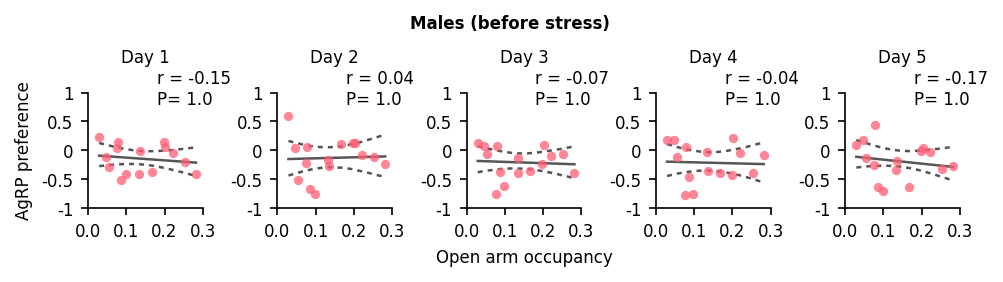

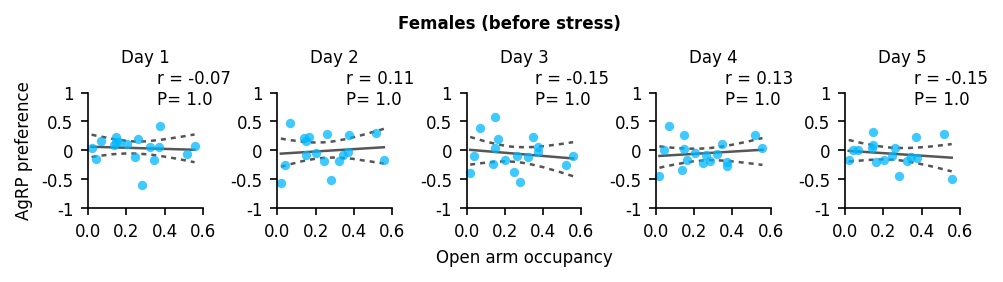

In [9]:
for s, sex in enumerate(['male', 'female']):
    fig, axs = plt.subplots(1,5,figsize=(5*1.5,1.), dpi=150)
    fig.subplots_adjust(wspace=0.65)
    fig.suptitle(f'{sex[0].upper()}{sex[1:]}s (before stress)', y=1.4, fontsize=8, fontweight='bold')
    
    axs[2].set_xlabel('Open arm occupancy')
    axs[0].set_ylabel('AgRP preference')
    
    pvals, rvals = [], []
    for d, day in enumerate([1,2,3,4,5]):
        df = data_df.query("@data_df.mouse.sex==@sex")
        
        X = df.loc[:, ('epm', 'ratio')].to_numpy()
        y = df.loc[:, ('test', day)].to_numpy()

        # Linear regression
        result = linregress(X, y)
        y_new = result.slope * np.array(X) + result.intercept

        # Calculate Pearson's correlation coefficient
        r, p = pearsonr(X, y)
        pvals.append(p)
        rvals.append(r)

        # Bootstrapping for the confidence interval
        resid = y_new - y # Calculate residuals
        y_boot = []
        for _ in range(10000):
            bootindex = np.random.randint
            result = linregress(X, y + resid[bootindex(0, len(resid) - 1, len(resid))])
            x_ = np.linspace(np.min(X),np.max(X))
            y_boot.append(result.slope*np.array(x_) + result.intercept)
        y_boot = np.array(y_boot)

        # Get the 95% confidence interval
        l_x = x_[np.argsort(x_)]
        l_upper = np.quantile(y_boot,0.975, axis=0)[np.argsort(x_)]
        l_lower = np.quantile(y_boot,0.025, axis=0)[np.argsort(x_)]
        
        # Plot the data
        ax = axs[d]

        ax.plot(l_x, l_upper, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(l_x, l_lower, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(X[np.argsort(X)], y_new[np.argsort(X)], color='#565656', linewidth=1.2, zorder=-1)

        ax.scatter(X, y, s=20, color=colors[sex], linewidth=0, alpha=0.75, clip_on=False, zorder=1)

        if sex=='male':
            ax.set_xlim([0,0.3])
            ax.set_xticks(np.linspace(0, 0.3, 4))
        else:
            ax.set_xlim([0,0.6])
            ax.set_xticks(np.linspace(0,0.6,4))

        ax.set_ylim([-1,1])

        ax.set_yticks([-1,-0.5,0,0.5,1])
        ax.set_yticklabels([-1,-0.5,0,0.5,1])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_title(f"Day {day}", y=1.15, fontsize=8)

    # Correct for multiple comparisons
    alpha = 0.05
    t, pcorrected, _, _ = multipletests(pvals, alpha=alpha, method='bonferroni')
    print(t, pcorrected)
    for i, p in enumerate(pcorrected):
        r = rvals[i]
        if p < alpha:
            txt = f'r = {np.round(r,2)}\n'+fr'$\bf{{P= {np.round(p,3)}}}$'
        else:
            txt = f'r = {np.round(r,2)}\n'+f'P= {np.round(p,3)}'
        axs[i].annotate(txt, xy=(0.6, 0.9), xycoords='axes fraction', fontsize=8)


[False False False False False] [0.95868728 1.         1.         1.         0.9598054 ]
[ True False False  True  True] [0.01215781 0.1496065  0.09062307 0.03681063 0.02462128]


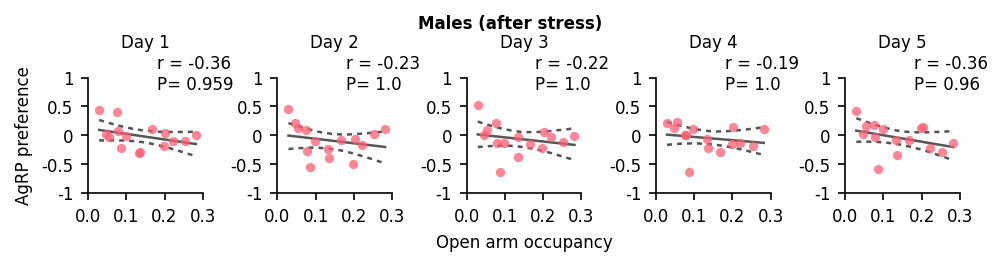

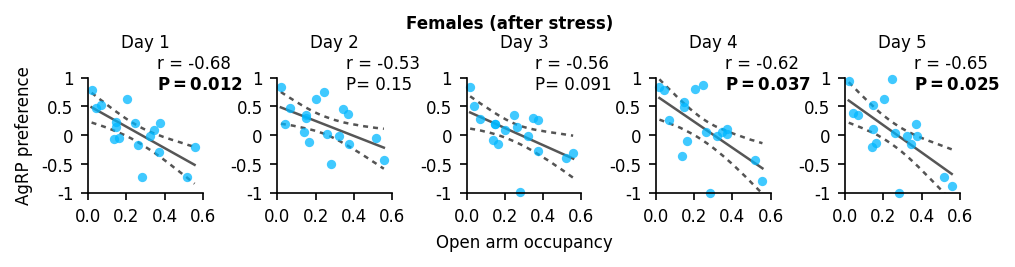

In [8]:
for s, sex in enumerate(['male', 'female']):
    fig, axs = plt.subplots(1,5,figsize=(5*1.5,1.), dpi=150)
    fig.subplots_adjust(wspace=0.65)
    fig.suptitle(f"{sex[0].upper()}{sex[1:]}s (after stress)", y=1.3, fontsize=8, fontweight='bold')
    
    axs[2].set_xlabel('Open arm occupancy')
    axs[0].set_ylabel('AgRP preference')
    
    pvals, rvals = [], []
    for d, day in enumerate([1,2,3,4,5]):
        df = data_df.query("@data_df.mouse.sex==@sex")
        
        X = df.loc[:, ('epm', 'ratio')].to_numpy()
        y = df.loc[:, ('test_', day)].to_numpy()

        # Linear regression
        result = linregress(X, y)
        y_new = result.slope * np.array(X) + result.intercept

        # Calculate Pearson's correlation coefficient
        r, p = pearsonr(X, y)
        pvals.append(p)
        rvals.append(r)

        # Bootstrapping for the confidence interval
        resid = y_new - y # Calculate residuals
        y_boot = []
        for _ in range(10000):
            bootindex = np.random.randint
            result = linregress(X, y + resid[bootindex(0, len(resid) - 1, len(resid))])
            x_ = np.linspace(np.min(X),np.max(X))
            y_boot.append(result.slope*np.array(x_) + result.intercept)
        y_boot = np.array(y_boot)

        # Get the 95% confidence interval
        l_x = x_[np.argsort(x_)]
        l_upper = np.quantile(y_boot,0.975, axis=0)[np.argsort(x_)]
        l_lower = np.quantile(y_boot,0.025, axis=0)[np.argsort(x_)]
        
        # Plot the data
        ax = axs[d]

        ax.plot(l_x, l_upper, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(l_x, l_lower, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(X[np.argsort(X)], y_new[np.argsort(X)], color='#565656', linewidth=1.2, zorder=-1)

        ax.scatter(X, y, s=20, color=colors[sex], linewidth=0, alpha=0.75, clip_on=False, zorder=1)

        if sex=='male':
            ax.set_xlim([0,0.3])
            ax.set_xticks(np.linspace(0, 0.3, 4))
        else:
            ax.set_xlim([0,0.6])
            ax.set_xticks(np.linspace(0,0.6,4))

        ax.set_ylim([-1,1])

        ax.set_yticks([-1,-0.5,0,0.5,1])
        ax.set_yticklabels([-1,-0.5,0,0.5,1])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_title(f"Day {day}", y=1.15, fontsize=8)

    # Correct for multiple comparisons
    alpha = 0.05
    t, pcorrected, _, _ = multipletests(pvals, alpha=alpha, method='bonferroni')
    print(t, pcorrected)
    for i, p in enumerate(pcorrected):
        r = rvals[i]
        if p < alpha:
            txt = f'r = {np.round(r,2)}\n'+fr'$\bf{{P= {np.round(p,3)}}}$'
        else:
            txt = f'r = {np.round(r,2)}\n'+f'P= {np.round(p,3)}'
        axs[i].annotate(txt, xy=(0.6, 0.9), xycoords='axes fraction', fontsize=8)


## Figures S3D and S3E

### Assessment of estrous cycle contribution
Potential contribution of the estrous phase is assesed by assessing the correlation between the EPM score evaluated in *Phase I* (see Figure 1A) and the maximum and minimum AgRP preferences across 5 days of RTPP fors each mouse.For details see *Evaluating the effect of the estrous on preferences* under Methods. 

[False False] [0.36474603 0.46413042]
[ True  True] [0.03481491 0.00089408]


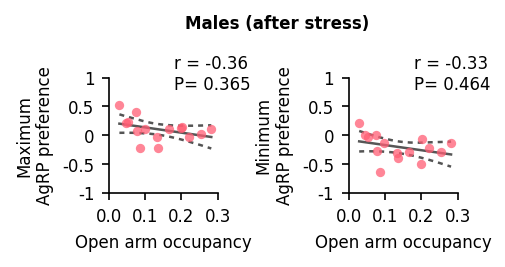

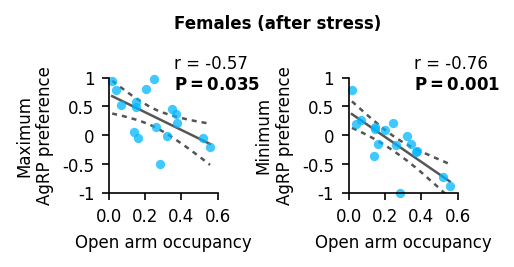

In [28]:
for s, sex in enumerate(['male', 'female']):
    fig, axs = plt.subplots(1,2,figsize=(2*1.5,1.), dpi=150)
    fig.subplots_adjust(wspace=1.2)
    fig.suptitle(f"{sex[0].upper()}{sex[1:]}s (after stress)", y=1.3, fontsize=8, fontweight='bold')
       
    df = data_df.query("@data_df.mouse.sex==@sex")
    
    ys = {'max':df.loc[:, 'test_'].max(axis=1).to_numpy(), 'min':df.loc[:, 'test_'].min(axis=1).to_numpy()}
    pvals, rvals = [], []
    for j, val in enumerate(['max','min']):
        X = df.loc[:, ('epm', 'ratio')].to_numpy()
        y = ys[val]
        # Linear regression
        result = linregress(X, y)
        y_new = result.slope * np.array(X) + result.intercept

        # Calculate Pearson's correlation coefficient
        r, p = pearsonr(X, y)
        pvals.append(p)
        rvals.append(r)

        # Bootstrapping for the confidence interval
        resid = y_new - y # Calculate residuals
        y_boot = []
        for _ in range(10000):
            bootindex = np.random.randint
            result = linregress(X, y + resid[bootindex(0, len(resid) - 1, len(resid))])
            x_ = np.linspace(np.min(X),np.max(X))
            y_boot.append(result.slope*np.array(x_) + result.intercept)
        y_boot = np.array(y_boot)

        # Get the 95% confidence interval
        l_x = x_[np.argsort(x_)]
        l_upper = np.quantile(y_boot,0.975, axis=0)[np.argsort(x_)]
        l_lower = np.quantile(y_boot,0.025, axis=0)[np.argsort(x_)]
        
        # Plot the data
        ax = axs[j]

        ax.plot(l_x, l_upper, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(l_x, l_lower, color=colors['darkgray'], linewidth=1.2, linestyle=(0,(2,2)), zorder=-1)
        ax.plot(X[np.argsort(X)], y_new[np.argsort(X)], color='#565656', linewidth=1.2, zorder=-1)

        ax.scatter(X, y, s=20, color=colors[sex], linewidth=0, alpha=0.75, clip_on=False, zorder=1)

        ax.set_ylabel(f'M{val[1:]}imum\nAgRP preference')
        ax.set_xlabel('Open arm occupancy')

        if sex=='male':
            ax.set_xlim([0,0.3])
            ax.set_xticks(np.linspace(0, 0.3, 4))
        else:
            ax.set_xlim([0,0.6])
            ax.set_xticks(np.linspace(0,0.6,4))

        ax.set_ylim([-1,1])

        ax.set_yticks([-1,-0.5,0,0.5,1])
        ax.set_yticklabels([-1,-0.5,0,0.5,1])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Correct for multiple comparisons
    alpha = 0.05
    t, pcorrected, _, _ = multipletests(pvals, alpha=alpha, method='bonferroni')
    print(t, pcorrected)
    for i, p in enumerate(pcorrected):
        r = rvals[i]
        if p < alpha:
            txt = f'r = {np.round(r,2)}\n'+fr'$\bf{{P= {np.round(p,3)}}}$'
        else:
            txt = f'r = {np.round(r,2)}\n'+f'P= {np.round(p,3)}'
        axs[i].annotate(txt, xy=(0.6, 0.9), xycoords='axes fraction', fontsize=8)
